In [4]:
import pandas as pd

# Load the file with PHQ8_Score
df = pd.read_csv("/Users/yubeiming/combined_PHQ8_scores.csv")

# Add binary label
df["PHQ8_Binary"] = (df["PHQ8_Score"] >= 10).astype(int)

# Save to new file
df.to_csv("/Users/yubeiming/combined_PHQ8_binary.csv", index=False)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6482 - loss: 0.6094 - val_accuracy: 0.6000 - val_loss: 0.6804
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6685 - loss: 0.6699 - val_accuracy: 0.6333 - val_loss: 0.6757
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7291 - loss: 0.5503 - val_accuracy: 0.6667 - val_loss: 0.6734
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7314 - loss: 0.5456 - val_accuracy: 0.7000 - val_loss: 0.6679
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7929 - loss: 0.5391 - val_accuracy: 0.7000 - val_loss: 0.6610
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8568 - loss: 0.5012 - val_accuracy: 0.6667 - val_loss: 0.6636
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7311 - loss: 0.5473 - val_accuracy: 0.6667 - val_loss: 0.6772
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8469 - loss: 0.4066 - val_accuracy: 0.7333 - val_loss: 0.6889
Epo

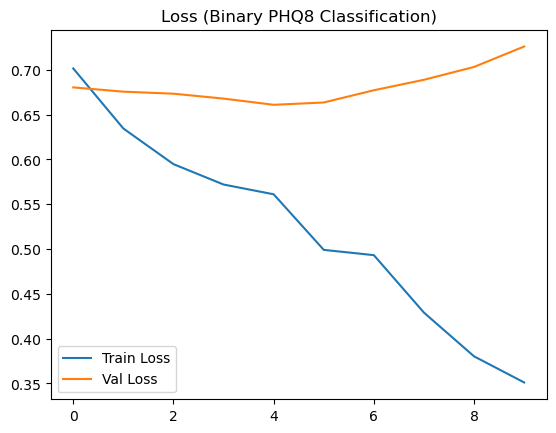

In [12]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load PHQ-8 binary labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Load and process COVAREP features ===
T = 100  # fixed time steps
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    df = pd.read_csv(file_path)
    vuv_col = next((col for col in df.columns if set(df[col].unique()).issubset({0, 1}) and df[col].nunique() == 2), None)
    if vuv_col is None: continue

    df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore").fillna(0)
    if len(df_voiced) < T:
        pad = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
        arr = np.vstack([df_voiced.values, pad])
    else:
        arr = df_voiced.values[:T]

    X_all.append(arr)
    y_all.append(phq_dict[pid])

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: Build and train LSTM ===
model = Sequential([
    LSTM(32, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                    class_weight=cw_dict, verbose=1)
# === Step 5: Evaluation ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.2f}")

# === Step 6: Loss Curve ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (Binary PHQ8 Classification)")
plt.legend()
plt.show()

Loaded 150 samples | Input shape: (150, 100, 73)
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2963 - loss: 0.7443 - val_accuracy: 0.3667 - val_loss: 0.7210
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4983 - loss: 0.6271 - val_accuracy: 0.3333 - val_loss: 0.7136
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5317 - loss: 0.6528 - val_accuracy: 0.4000 - val_loss: 0.7071
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7742 - loss: 0.5165 - val_accuracy: 0.4333 - val_loss: 0.6927
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7876 - loss: 0.5746 - val_accuracy: 0.5333 - val_loss: 0.6937
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8580 - loss: 0.4540 - val_accuracy: 0.4667 - val_loss: 0.7934
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8963 - loss: 0.3592 - val_accuracy: 0.5667 - val_loss: 0.7467
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9636 - loss: 0.1806 - val_accuracy: 0.6000 - val_loss: 0.

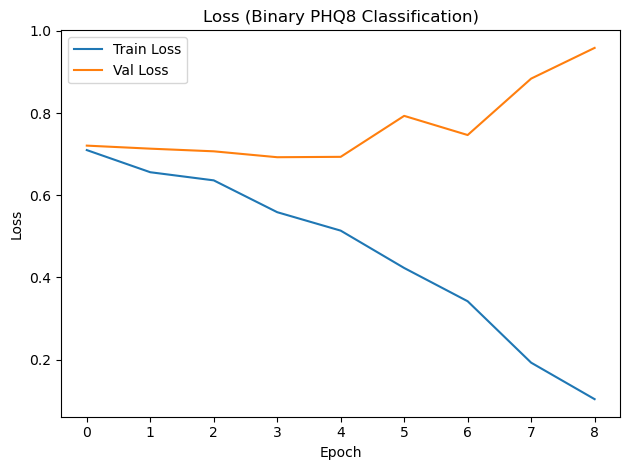

In [14]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load PHQ-8 binary labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Load and process COVAREP features ===
T = 100  # fixed time steps (truncate or pad)
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    try:
        df = pd.read_csv(file_path)
        vuv_col = next((col for col in df.columns 
                        if set(df[col].dropna().unique()).issubset({0, 1}) and df[col].nunique() == 2), None)
        if vuv_col is None:
            continue
        df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore").fillna(0)
        if len(df_voiced) < T:
            pad = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
            arr = np.vstack([df_voiced.values, pad])
        else:
            arr = df_voiced.values[:T]
        X_all.append(arr)
        y_all.append(phq_dict[pid])
    except Exception as e:
        print(f"[Error] {file_path}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)

print(f"Loaded {X_all.shape[0]} samples | Input shape: {X_all.shape}")

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: Build stacked LSTM model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Step 6: Evaluation ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# === Step 7: Loss Plot ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (Binary PHQ8 Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


✅ Loaded 150 samples | Input shape: (150, 100, 74)
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3792 - loss: 0.7675 - val_accuracy: 0.2000 - val_loss: 0.7424
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5361 - loss: 0.7250 - val_accuracy: 0.3000 - val_loss: 0.7388
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3877 - loss: 0.6852 - val_accuracy: 0.4000 - val_loss: 0.7218
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5449 - loss: 0.6770 - val_accuracy: 0.4667 - val_loss: 0.7221
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6573 - loss: 0.5955 - val_accuracy: 0.5667 - val_loss: 0.7190
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6243 - loss: 0.5368 - val_accuracy: 0.5667 - val_loss: 0.7123
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8909 - loss: 0.4718 - val_accuracy: 0.5667 - val_loss: 0.7389
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8952 - loss: 0.4117 - val_accuracy: 0.5667 - val_loss: 0.7

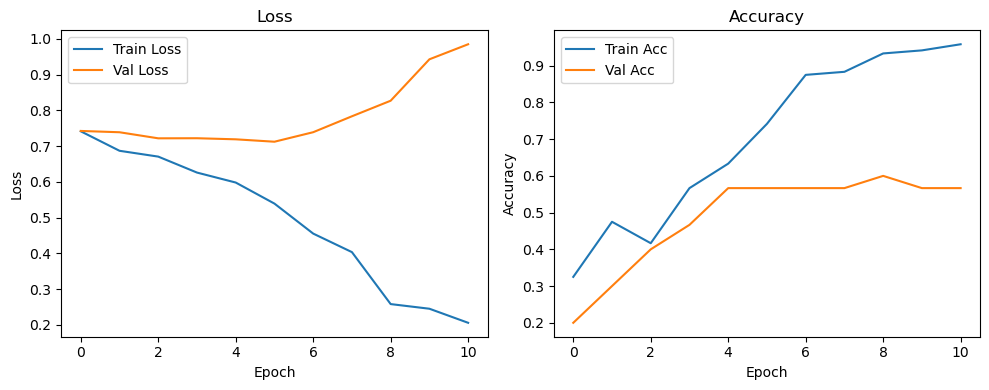

In [18]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load PHQ-8 binary labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Load and process full COVAREP features (no VUV filtering) ===
T = 100  # number of time steps
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    try:
        df = pd.read_csv(file_path)
        df = df.drop(columns=["Time"], errors="ignore")
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(0)

        if len(df) < T:
            pad = np.zeros((T - len(df), df.shape[1]))
            arr = np.vstack([df.values, pad])
        else:
            arr = df.values[:T]

        X_all.append(arr)
        y_all.append(phq_dict[pid])
    except Exception as e:
        print(f"[Error] {file_path}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)

# Final sanitize for safety
X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)

print(f"✅ Loaded {X_all.shape[0]} samples | Input shape: {X_all.shape}")

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: Build smaller LSTM model ===
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    LSTM(16),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train model ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Step 6: Evaluate ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# === Step 7: Plot Loss & Accuracy Curves ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


✅ Loaded 150 samples | Input shape: (150, 200, 74)
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5534 - loss: 0.6703 - val_accuracy: 0.5667 - val_loss: 0.6831
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5462 - loss: 0.7520 - val_accuracy: 0.5000 - val_loss: 0.6839
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5306 - loss: 0.7118 - val_accuracy: 0.5333 - val_loss: 0.6854
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6946 - loss: 0.6147 - val_accuracy: 0.5000 - val_loss: 0.6855
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7302 - loss: 0.6049 - val_accuracy: 0.5000 - val_loss: 0.6868
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6816 - loss: 0.6150 - val_accuracy: 0.5000 - val_loss: 0.6914

✅ Test Accuracy: 0.57


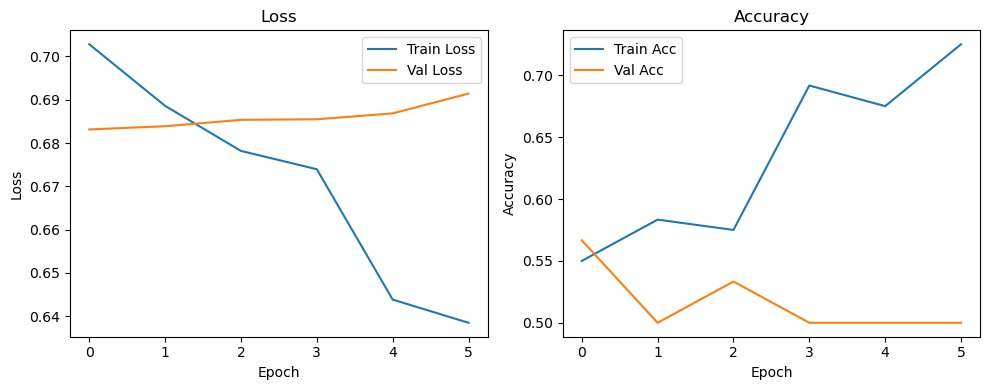

In [20]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load PHQ-8 binary labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Load and process full COVAREP features ===
T = 200  # longer time window
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    try:
        df = pd.read_csv(file_path)
        df = df.drop(columns=["Time"], errors="ignore")
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(0)

        if len(df) < T:
            pad = np.zeros((T - len(df), df.shape[1]))
            arr = np.vstack([df.values, pad])
        else:
            arr = df.values[:T]

        X_all.append(arr)
        y_all.append(phq_dict[pid])
    except Exception as e:
        print(f"[Error] {file_path}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)
X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)

print(f"✅ Loaded {X_all.shape[0]} samples | Input shape: {X_all.shape}")

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: Build improved LSTM model ===
model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(timesteps, nfeatures)),
    Dropout(0.4),
    LSTM(16),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train model ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Step 6: Evaluate ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# === Step 7: Plot Loss & Accuracy Curves ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


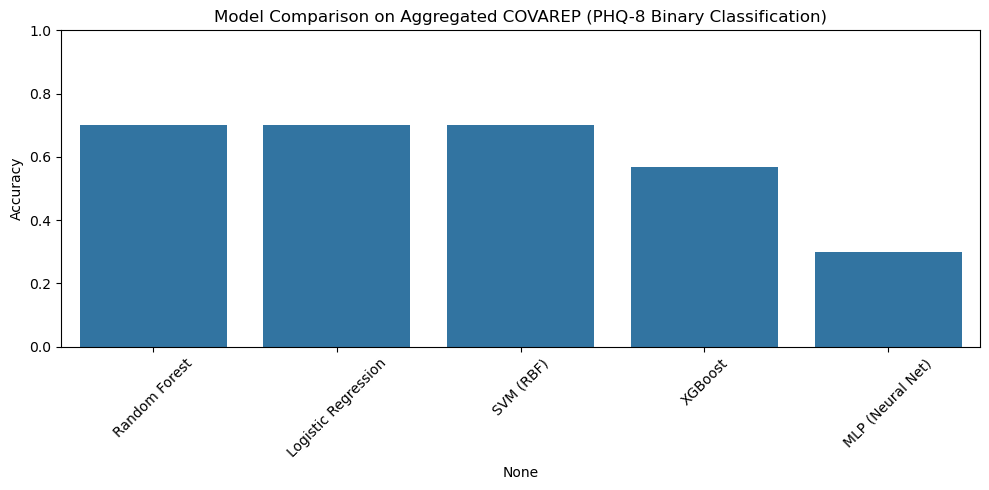

In [28]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load PHQ-8 Labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Aggregate COVAREP Features ===
COVAREP_DIR = "/Users/yubeiming/Depression"
features = []

for file_path in glob(os.path.join(COVAREP_DIR, "*_P", "*_COVAREP.csv")):
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue
    try:
        df = pd.read_csv(file_path)
        df = df.drop(columns=["Time"], errors="ignore")
        df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

        agg = df.agg(['mean', 'std', 'min', 'max', 'skew'])
        flat_features = {}
        for feature_name in df.columns:
            for stat in ['mean', 'std', 'min', 'max', 'skew']:
                flat_features[f"{feature_name}_{stat}"] = agg.loc[stat, feature_name]

        flat_features["Participant_ID"] = pid
        features.append(flat_features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

feature_df = pd.DataFrame(features)
merged = pd.merge(labels_df, feature_df, on="Participant_ID", how="inner")

# === Step 3: Prepare Features & Labels ===
X = merged.drop(columns=["Participant_ID", "PHQ8_Score", "PHQ8_Binary"]).fillna(0)
y = merged["PHQ8_Binary"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Step 4: Define & Train Models ===
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF)": SVC(probability=True),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# === Step 5: Visualize Accuracy Comparison ===
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['Accuracy'])
plt.title("Model Comparison on Aggregated COVAREP (PHQ-8 Binary Classification)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
✅ Test Accuracy: 0.70 | AUC: 0.55


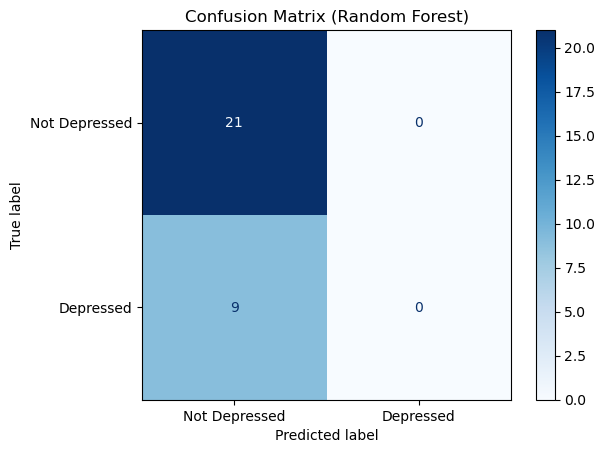

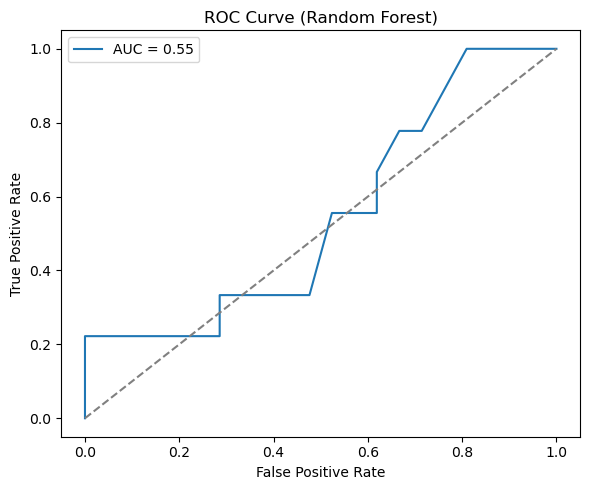

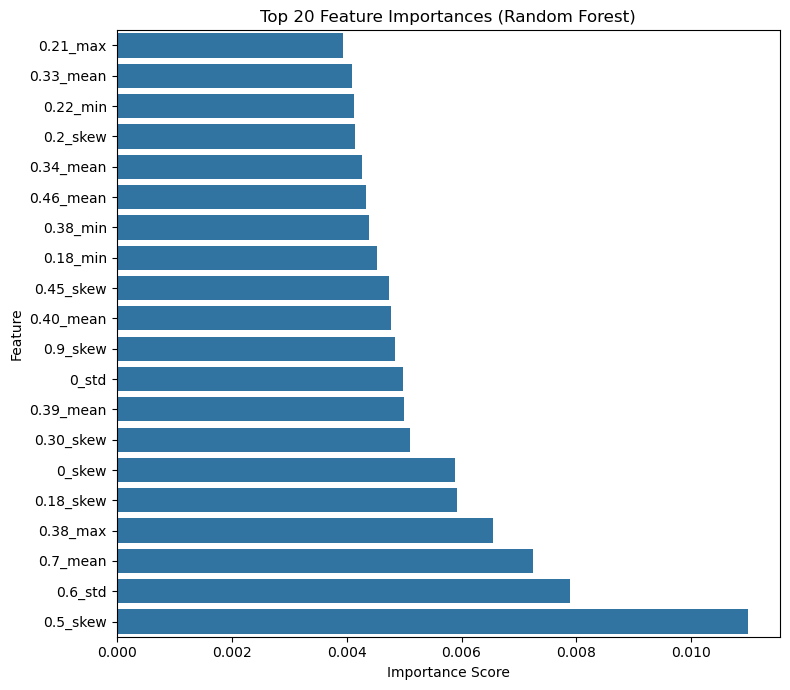

In [30]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# === Step 1: GridSearchCV for Random Forest ===
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print(f"\n✅ Best Parameters: {grid.best_params_}")

# === Step 2: Evaluate Best Model ===
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"✅ Test Accuracy: {acc:.2f} | AUC: {auc:.2f}")

# === Step 3: Plot Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Depressed", "Depressed"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

# === Step 4: Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

# === Step 5: Plot Feature Importances ===
importances = best_rf.feature_importances_
feature_names = X.columns
top_idx = np.argsort(importances)[-20:]  # top 20 features

plt.figure(figsize=(8, 7))
sns.barplot(x=importances[top_idx], y=feature_names[top_idx])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4730 - auc: 0.5476 - loss: 0.7405 - val_accuracy: 0.6333 - val_auc: 0.4575 - val_loss: 0.6734
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5879 - auc: 0.6819 - loss: 0.6249 - val_accuracy: 0.6667 - val_auc: 0.4800 - val_loss: 0.6660
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6539 - auc: 0.8223 - loss: 0.5696 - val_accuracy: 0.6667 - val_auc: 0.5200 - val_loss: 0.6740
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7726 - auc: 0.8403 - loss: 0.4761 - val_accuracy: 0.6000 - val_auc: 0.5200 - val_loss: 0.7023
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7971 - auc: 0.9108 - loss: 0.4360 - val_accuracy: 0.5667 - val_auc: 0.4800 - val_loss: 0.6901
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7354 - auc: 0.9137 - loss: 0.4340 - val_accuracy: 0.6000 - val_auc: 0.5250 - val_loss: 0.7348
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 

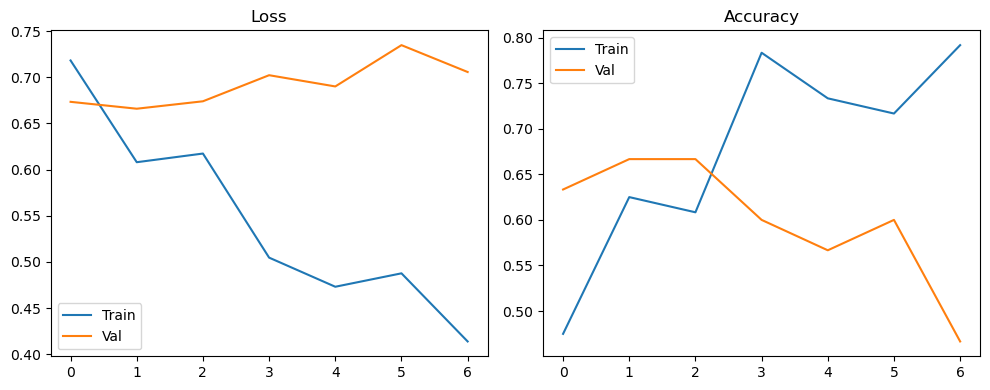

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt

# === Step 1: Assume you've built these already ===
# X_all: shape [n_samples, T, n_features]
# y_all: binary labels [n_samples]
T = 200  # sequence length
X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)
y_all = np.array(y_all)

# === Step 2: Normalize ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

# === Step 3: Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: CNN Model ===
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(timesteps, nfeatures)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name="auc")])

# === Step 5: Train ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Step 6: Evaluate ===
loss, acc, auc_score = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f} | AUC: {auc_score:.2f}")

# === Step 7: Plot Training Curves ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5397 - auc: 0.4993 - loss: 0.7076 - val_accuracy: 0.3667 - val_auc: 0.5000 - val_loss: 0.6933
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6181 - auc: 0.6625 - loss: 0.7209 - val_accuracy: 0.5333 - val_auc: 0.5000 - val_loss: 0.6927
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7026 - auc: 0.6810 - loss: 0.6973 - val_accuracy: 0.6333 - val_auc: 0.5750 - val_loss: 0.6913
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7088 - auc: 0.7524 - loss: 0.7215 - val_accuracy: 0.6333 - val_auc: 0.5200 - val_loss: 0.6909
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8648 - auc: 0.9250 - loss: 0.7164 - val_accuracy: 0.6000 - val_auc: 0.5000 - val_loss: 0.6895
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9244 - auc: 0.9748 - loss: 0.6717 - val_accuracy: 0.6000 - val_auc: 0.4975 - val_loss: 0.6866
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/

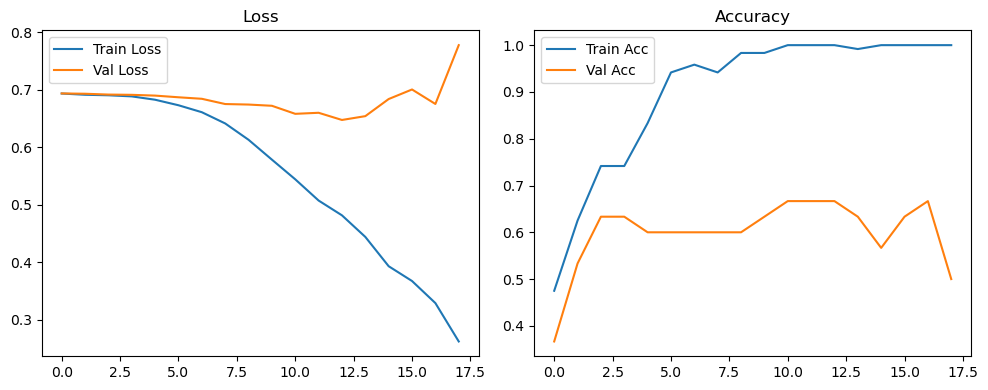

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Attention, Permute, Multiply, Lambda
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, Activation

# === Assume these are already loaded ===
# X_all: shape [n_samples, T, n_features]
# y_all: binary labels

T = 200
X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)
y_all = np.array(y_all)

# === Normalize and Split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Define Attention Layer ===
def attention_block(inputs):
    score = Dense(1, activation='tanh')(inputs)
    score = Flatten()(score)
    attention_weights = Activation('softmax')(score)
    attention_weights = RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    output = Multiply()([inputs, attention_weights])
    return output

# === Model Definition ===
inputs = Input(shape=(timesteps, nfeatures))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Attention mechanism
attention_weights = Dense(1, activation='tanh')(x)
attention_weights = Flatten()(attention_weights)
attention_weights = Dense(timesteps, activation='softmax')(attention_weights)
attention_weights = RepeatVector(x.shape[-1])(attention_weights)
attention_weights = Permute([2, 1])(attention_weights)
x = Multiply()([x, attention_weights])

x = GlobalAveragePooling1D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name="auc")])

# === Train Model ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Evaluate ===
loss, acc, auc_score = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f} | AUC: {auc_score:.2f}")

# === Plot Curves ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3498 - loss: 0.7311 - val_accuracy: 0.6333 - val_loss: 0.6888
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6672 - loss: 0.6983 - val_accuracy: 0.7000 - val_loss: 0.6852
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6972 - loss: 0.6915 - val_accuracy: 0.6333 - val_loss: 0.6599
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7452 - loss: 0.6403 - val_accuracy: 0.6000 - val_loss: 0.6709
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8320 - loss: 0.4784 - val_accuracy: 0.5333 - val_loss: 0.6782
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7784 - loss: 0.4837 - val_accuracy: 0.6667 - val_loss: 0.6771
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8451 - loss: 0.3854 - val_accuracy: 0.6667 - val_loss: 0.7360
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8583 - loss: 0.4074 - val_accuracy: 0.6000 - val_loss:

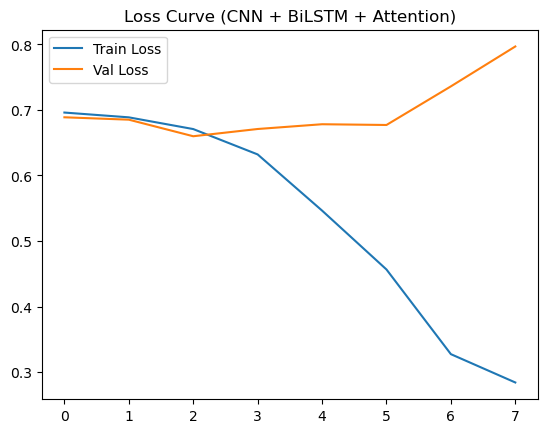

In [40]:
import os
import numpy as np
import pandas as pd
import librosa
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Bidirectional,
    Dense, Dropout, Flatten, Attention, Multiply, Permute, RepeatVector, Activation
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load binary PHQ8 labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Extract MFCCs ===
T = 100  # fixed time steps
X_all, y_all = [], []
audio_paths = glob("/Users/yubeiming/Depression/*_P/*_AUDIO.wav")

for path in audio_paths:
    pid = os.path.basename(path).split("_")[0]
    if pid not in phq_dict:
        continue
    try:
        y, sr = librosa.load(path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc = mfcc.T[:T]  # Trim/pad to T
        if mfcc.shape[0] < T:
            pad = np.zeros((T - mfcc.shape[0], mfcc.shape[1]))
            mfcc = np.vstack([mfcc, pad])
        X_all.append(mfcc)
        y_all.append(phq_dict[pid])
    except Exception as e:
        print(f"Failed to process {path}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: CNN + BiLSTM + Attention ===
inputs = Input(shape=(timesteps, nfeatures))
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)

# Attention mechanism
attention = Dense(1, activation='tanh')(x)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(64)(attention)
attention = Permute([2, 1])(attention)
x = Multiply()([x, attention])
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=4, class_weight=cw_dict,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                    verbose=1)

# === Step 6: Evaluate ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.2f}")

# === Step 7: Plot Loss ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve (CNN + BiLSTM + Attention)")
plt.show()


In [42]:
import os
import numpy as np
import pandas as pd
import librosa
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten, Multiply, Permute, RepeatVector, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# === Load labels ===
label_df = pd.read_csv("/Users/yubeiming/combined_PHQ8_scores.csv")
label_df["Participant_ID"] = label_df["Participant_ID"].astype(str)
label_df["PHQ8_Binary"] = (label_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(label_df["Participant_ID"], label_df["PHQ8_Binary"]))

# === Extract 40 MFCC features ===
T = 100
X_all, y_all = [], []
audio_files = glob("/Users/yubeiming/Depression/*_P/*_AUDIO.wav")

for path in audio_files:
    pid = os.path.basename(path).split("_")[0]
    if pid not in phq_dict:
        continue
    try:
        y, sr = librosa.load(path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc = mfcc.T
        if mfcc.shape[0] < T:
            pad = np.zeros((T - mfcc.shape[0], 40))
            mfcc = np.vstack([mfcc, pad])
        else:
            mfcc = mfcc[:T]
        X_all.append(mfcc)
        y_all.append(phq_dict[pid])
    except:
        continue

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Normalize & split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Attention Mechanism ===
def attention_layer(inputs):
    score = Dense(1, activation='tanh')(inputs)
    score = Flatten()(score)
    score = Activation('softmax')(score)
    score = RepeatVector(inputs.shape[-1])(score)
    score = Permute([2, 1])(score)
    return Multiply()([inputs, score])

# === CNN + BiLSTM + Attention Model ===
inputs = Input(shape=(T, 40))
x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = attention_layer(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs, output)

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])

# === Train ===
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=4,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          class_weight=cw_dict, verbose=1)

# === Evaluate ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.2f}")


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5053 - loss: 1.9196 - val_accuracy: 0.3333 - val_loss: 1.0970
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4154 - loss: 1.0758 - val_accuracy: 0.3333 - val_loss: 0.9118
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4313 - loss: 0.9173 - val_accuracy: 0.6000 - val_loss: 0.8374
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5632 - loss: 0.8071 - val_accuracy: 0.5000 - val_loss: 0.7912
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5402 - loss: 0.7988 - val_accuracy: 0.6667 - val_loss: 0.7599
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6463 - loss: 0.7969 - val_accuracy: 0.6000 - val_loss: 0.7403
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7168 - loss: 0.7507 - val_accuracy: 0.6000 - val_loss: 0.7256
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7825 - loss: 0.6607 - val_accuracy: 0.6000 - val_loss:

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4202 - loss: 1.1342 - val_accuracy: 0.6667 - val_loss: 0.7673
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5941 - loss: 0.7555 - val_accuracy: 0.6000 - val_loss: 0.7051
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8185 - loss: 0.6460 - val_accuracy: 0.5667 - val_loss: 0.6971
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6784 - loss: 0.7051 - val_accuracy: 0.5333 - val_loss: 0.6985
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6866 - loss: 0.6968 - val_accuracy: 0.5333 - val_loss: 0.7224
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6042 - loss: 0.6621 - val_accuracy: 0.6000 - val_loss: 0.7103
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.5971 - val_accuracy: 0.5333 - val_loss: 0.7872
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7508 - loss: 0.5579 - val_accuracy: 0.6333 - val_loss:

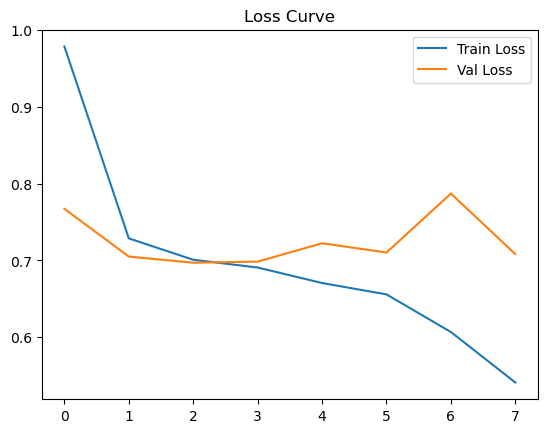

In [52]:
import os
import numpy as np
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Multiply, Permute, RepeatVector, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load Labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: MFCC extraction setup ===
T_FIXED = 100  # time steps
MFCC_DIM = 40
AUDIO_DIR = "/Users/yubeiming/Depression"
mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=MFCC_DIM,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": MFCC_DIM}
)

X_all, y_all = [], []
folders = glob(os.path.join(AUDIO_DIR, "*_P"))
for folder in folders:
    pid = os.path.basename(folder).split("_")[0]
    if pid not in phq_dict:
        continue

    audio_path = os.path.join(folder, f"{pid}_AUDIO.wav")
    if not os.path.exists(audio_path):
        continue

    try:
        waveform, sr = torchaudio.load(audio_path)
        if sr != 16000:
            resampler = T.Resample(sr, 16000)
            waveform = resampler(waveform)
        mfcc = mfcc_transform(waveform).squeeze(0).transpose(0, 1).numpy()  # shape (T, 40)

        if mfcc.shape[0] < T_FIXED:
            pad = np.zeros((T_FIXED - mfcc.shape[0], MFCC_DIM))
            mfcc = np.vstack([mfcc, pad])
        else:
            mfcc = mfcc[:T_FIXED, :]

        X_all.append(mfcc)
        y_all.append(phq_dict[pid])
    except Exception as e:
        print(f"[Error] {pid}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw_dict = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))

# === Step 4: CNN + BiLSTM + Attention Model ===
inputs = Input(shape=(timesteps, nfeatures))
x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.5)(x)

# Attention mechanism based on dynamic shape
attention_weights = Dense(1, activation='tanh')(x)
attention_weights = Flatten()(attention_weights)
attention_weights = Dense(x.shape[1], activation='softmax')(attention_weights)
attention_weights = RepeatVector(64)(attention_weights)
attention_weights = Permute([2, 1])(attention_weights)
attended = Multiply()([x, attention_weights])
attended = Flatten()(attended)

x = Dense(32, activation='relu', kernel_regularizer='l2')(attended)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Step 6: Evaluation ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# === Step 7: Plot ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5148 - loss: 0.7436 - val_accuracy: 0.5667 - val_loss: 0.6804
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5914 - loss: 0.6646 - val_accuracy: 0.6000 - val_loss: 0.6794
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7377 - loss: 0.5375 - val_accuracy: 0.6667 - val_loss: 0.6715
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 0.5230 - val_accuracy: 0.7000 - val_loss: 0.6617
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8329 - loss: 0.4990 - val_accuracy: 0.6667 - val_loss: 0.6494
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9266 - loss: 0.4165 - val_accuracy: 0.6000 - val_loss: 0.6415
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 0.3950 - val_accuracy: 0.6000 - val_loss: 0.6386
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9685 - loss: 0.2949 - val_accuracy: 0.6000 - val_loss: 0.6352
Epo

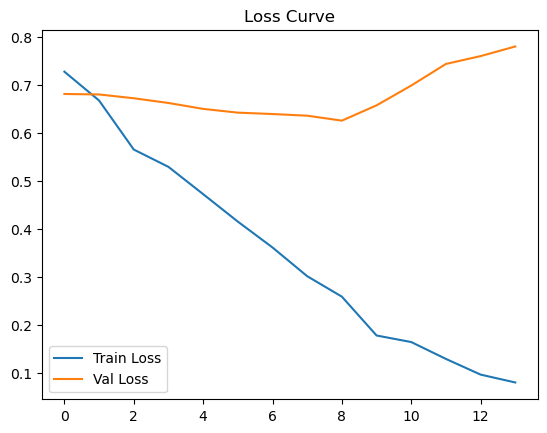

In [58]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Load labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Load COVAREP features ===
T = 100
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    df = pd.read_csv(file_path)
    vuv_col = next((col for col in df.columns if set(df[col].dropna().unique()).issubset({0, 1}) and df[col].nunique() == 2), None)
    if vuv_col is None:
        continue

    df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore").fillna(0)
    if len(df_voiced) < T:
        pad = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
        arr = np.vstack([df_voiced.values, pad])
    else:
        arr = df_voiced.values[:T]

    X_all.append(arr)
    y_all.append(phq_dict[pid])

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Normalize ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

# === Split and weights ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Original LSTM model ===
model = Sequential([
    LSTM(32, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Evaluate ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# === Plot ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()
